In [6]:
import argparse
import cv2

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import STL10
from torchvision.models.resnet import resnet18, resnet34, resnet50


from PIL import Image
from tqdm import tqdm

from __future__ import print_function

import os, sys, tarfile, errno
import matplotlib.pyplot as plt
    
if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib
else:
    import urllib

try:
    from imageio import imsave
except:
    from scipy.misc import imsave

sns.set(palette="Set2", font_scale=1.3)

### Load STL-10 Dataset

In [ ]:
# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

In [ ]:
def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [ ]:
download_and_extract()

### Utilities

In [ ]:
np.random.seed(0)

In [ ]:
class STL10Pair(STL10):
    def __getitem__(self, index):
        img, target = self.data[index], self.labels[index]
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        return pos_1, pos_2, target

In [ ]:
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return sample

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(kernel_size=int(0.1 * 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

### Model

In [ ]:
# class Model(nn.Module):
#     def __init__(self, feature_dim=128):
#         super(Model, self).__init__()

#         self.f = []
#         for name, module in resnet50().named_children():
#             if name == 'conv1':
#                 module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#             if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
#                 self.f.append(module)
#         # encoder
#         self.f = nn.Sequential(*self.f)
#         # projection head
#         self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
#                                nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))

#     def forward(self, x):
#         x = self.f(x)
#         feature = torch.flatten(x, start_dim=1)
#         out = self.g(feature)
#         return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)

In [ ]:
class Model(nn.Module):
    def __init__(self, feature_dim=128, arch="resnet18"):
        super(Model, self).__init__()

        self.f = []

        if arch == "resnet18":
            module = resnet18()
            in_size = 512
        elif arch == "resnet34":
            module = resnet34()
            in_size = 512
        elif arch == "resnet50":
            module = resnet50()
            in_size = 2048
        else:
            raise Exception("Unknown module {}".format(repr(arch)))
        for name, module in module.named_children():
            if name == "conv1":
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        # projection head
        self.g = nn.Sequential(
            nn.Linear(in_size, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, feature_dim, bias=True),
        )

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)

### Experiment

In [ ]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0

    negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

In [ ]:
def train(net, data_loader, train_optimizer, temperature, debiased, tau_plus):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for pos_1, pos_2, target in train_bar:
        pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)
        feature_1, out_1 = net(pos_1)
        feature_2, out_2 = net(pos_2)

        # neg score
        out = torch.cat([out_1, out_2], dim=0)
        neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
        mask = get_negative_mask(batch_size).cuda()
        neg = neg.masked_select(mask).view(2 * batch_size, -1)

        # pos score
        pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
        pos = torch.cat([pos, pos], dim=0)

        # estimator g()
        if debiased:
            N = batch_size * 2 - 2
            Ng = (-tau_plus * N * pos + neg.sum(dim = -1)) / (1 - tau_plus)
            # constrain (optional)
            Ng = torch.clamp(Ng, min = N * np.e**(-1 / temperature))
        else:
            Ng = neg.sum(dim=-1)

        # contrastive loss
        loss = (- torch.log(pos / (pos + Ng) )).mean()

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size

        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num

In [ ]:
# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader):
    net.eval()
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.labels, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)

            total_num += data.size(0)
            # compute cos similarity between each feature vector and feature bank ---> [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1).long(), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('KNN Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train SimCLR')
    parser.add_argument('--feature_dim', default=128, type=int, help='Feature dim for latent vector')
    parser.add_argument('--temperature', default=0.5, type=float, help='Temperature used in softmax')
    parser.add_argument('--tau_plus', default=0.1, type=float, help='Positive class priorx')
    parser.add_argument('--k', default=200, type=int, help='Top k most similar images used to predict the label')
    parser.add_argument('--batch_size', default=256, type=int, help='Number of images in each mini-batch')
    parser.add_argument('--epochs', default=500, type=int, help='Number of sweeps over the dataset to train')
    parser.add_argument('--debiased', default=True, type=bool, help='Debiased contrastive loss or standard loss')

    # # args parse
    # args = parser.parse_args()
    # feature_dim, temperature, tau_plus, k = args.feature_dim, args.temperature, args.tau_plus, args.k
    # batch_size, epochs, debiased = args.batch_size, args.epochs,  args.debiased
    feature_dim = 128
    temperature = 0.5
    tau_plus = 0.1
    k = 200
    batch_size = 256
    epochs = 50
    debiased = True

    # data prepare
    train_data = STL10Pair(root='data', split='train+unlabeled', transform=train_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
                              drop_last=True)
    memory_data = STL10Pair(root='data', split='train', transform=test_transform)
    memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_data = STL10Pair(root='data', split='test', transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # model setup and optimizer config
    model = Model(feature_dim).cuda()
    model = nn.DataParallel(model)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    c = len(memory_data.classes)
    print('# Classes: {}'.format(c))

    train_losses = []
    test_accs_1 = []
    test_accs_5 = []

    # training loop
    if not os.path.exists('results'):
        os.mkdir('results')
    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, optimizer, temperature, debiased, tau_plus)
        train_losses.append(train_loss)
        test_acc_1, test_acc_5 = test(model, memory_loader, test_loader)
        test_accs_1.append(test_acc_1)
        test_accs_5.append(test_acc_5)
        torch.save(model.state_dict(), 'results/model_{}.pth'.format(epoch))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Classes: 10


Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
KNN Test Epoch: [10/50] Acc@1:62.22% Acc@5:97.89%: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
KNN Test Epoch: [11/50] Acc@1:62.66% Acc@5:97.95%: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
KNN Test Epoch: [12/50] Acc@1:64.08% Acc@5:98.04%: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
KNN Test Epoch: [13/50] Acc@1:64.28% Acc@5:98.16%: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
KNN Test Epoch: [14/50] Acc@1:63.90% Acc@5:98.11%: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
KNN Test Epoch: [15/50] Acc@1:64.34% Acc@5:98.29%: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Train SimCLR')
    parser.add_argument('--feature_dim', default=128, type=int, help='Feature dim for latent vector')
    parser.add_argument('--temperature', default=0.5, type=float, help='Temperature used in softmax')
    parser.add_argument('--tau_plus', default=0.1, type=float, help='Positive class priorx')
    parser.add_argument('--k', default=200, type=int, help='Top k most similar images used to predict the label')
    parser.add_argument('--batch_size', default=256, type=int, help='Number of images in each mini-batch')
    parser.add_argument('--epochs', default=500, type=int, help='Number of sweeps over the dataset to train')
    parser.add_argument('--debiased', default=True, type=bool, help='Debiased contrastive loss or standard loss')

    # # args parse
    # args = parser.parse_args()
    # feature_dim, temperature, tau_plus, k = args.feature_dim, args.temperature, args.tau_plus, args.k
    # batch_size, epochs, debiased = args.batch_size, args.epochs,  args.debiased
    feature_dim = 128
    temperature = 0.5
    tau_plus = 0.1
    k = 200
    batch_size = 256
    epochs = 50
    debiased = False

    # data prepare
    train_data = STL10Pair(root='data', split='train+unlabeled', transform=train_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
                              drop_last=True)
    memory_data = STL10Pair(root='data', split='train', transform=test_transform)
    memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_data = STL10Pair(root='data', split='test', transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # model setup and optimizer config
    model = Model(feature_dim).cuda()
    model = nn.DataParallel(model)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    c = len(memory_data.classes)
    print('# Classes: {}'.format(c))

    train_losses = []
    test_accs_1_biased = []
    test_accs_5_biased = []

    # training loop
    if not os.path.exists('results'):
        os.mkdir('results')
    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, optimizer, temperature, debiased, tau_plus)
        train_losses.append(train_loss)
        test_acc_1, test_acc_5 = test(model, memory_loader, test_loader)
        test_accs_1_biased.append(test_acc_1)
        test_accs_5_biased.append(test_acc_5)
        torch.save(model.state_dict(), 'results/model_{}.pth'.format(epoch))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Classes: 10


Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
KNN Test Epoch: [10/50] Acc@1:62.54% Acc@5:97.84%: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
KNN Test Epoch: [11/50] Acc@1:62.20% Acc@5:97.85%: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
KNN Test Epoch: [12/50] Acc@1:63.29% Acc@5:97.91%: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
KNN Test Epoch: [13/50] Acc@1:63.31% Acc@5:98.04%: 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
KNN Test Epoch: [14/50] Acc@1:63.89% Acc@5:98.00%: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]
Feature extracting: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
KNN Test Epoch: [15/50] Acc@1:63.99% Acc@5:98.31%: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s

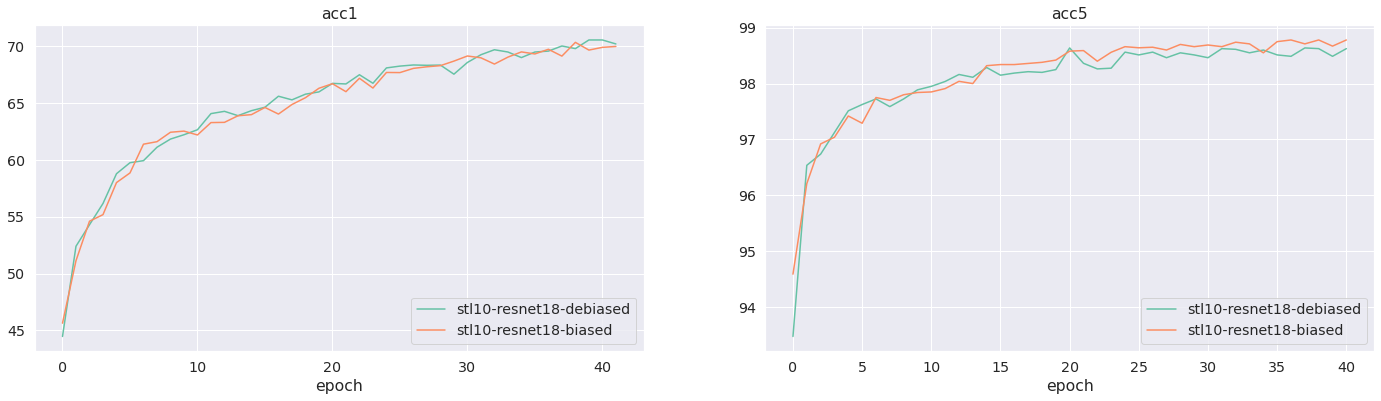

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
ax1.plot(test_accs_1, label="stl10-resnet18-debiased")
ax1.plot(test_accs_1_biased, label="stl10-resnet18-biased")
ax1.set_title("acc1")
ax1.legend(loc='lower right')
ax1.set_xlabel("epoch")
ax2.plot(test_accs_5, label="stl10-resnet18-debiased")
ax2.plot(test_accs_5_biased, label="stl10-resnet18-biased")
ax2.set_title("acc5")
ax2.legend(loc='lower right')
ax2.set_xlabel("epoch")

plt.show()

### Linear evaluation

In [ ]:
class Net(nn.Module):
    def __init__(self, num_class, pretrained_path):
        super(Net, self).__init__()

        # encoder
        model = Model().cuda()
        model = nn.DataParallel(model)
        model.load_state_dict(torch.load(pretrained_path))

        self.f = model.module.f
        # classifier
        self.fc = nn.Linear(2048, num_class, bias=True)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out

In [ ]:
# train or test for one epoch
def train_val(net, data_loader, train_optimizer):
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    total_loss, total_correct_1, total_correct_5, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader)
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            out = net(data)
            loss = loss_criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()

            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_5 += torch.sum((prediction[:, 0:5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            data_bar.set_description('{} Epoch: [{}/{}] Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}%'
                                     .format('Train' if is_train else 'Test', epoch, epochs, total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_5 / total_num * 100))

    return total_loss / total_num, total_correct_1 / total_num * 100, total_correct_5 / total_num * 100

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Linear Evaluation')
    parser.add_argument('--model_path', type=str, default='results/model_400.pth',
                        help='The pretrained model path')
    parser.add_argument('--batch_size', type=int, default=512, help='Number of images in each mini-batch')
    parser.add_argument('--epochs', type=int, default=100, help='Number of sweeps over the dataset to train')

    args = parser.parse_args()
    model_path, batch_size, epochs = args.model_path, args.batch_size, args.epochs
    train_data = STL10(root='data', split='train', transform=train_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_data = STL10(root='data', split='test', transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = Net(num_class=len(train_data.classes), pretrained_path=model_path).cuda()
    for param in model.f.parameters():
        param.requires_grad = False
    model = nn.DataParallel(model)

    optimizer = optim.Adam(model.module.fc.parameters(), lr=1e-3, weight_decay=1e-6)
    loss_criterion = nn.CrossEntropyLoss()
    results = {'train_loss': [], 'train_acc@1': [], 'train_acc@5': [],
               'test_loss': [], 'test_acc@1': [], 'test_acc@5': []}

    for epoch in range(1, epochs + 1):
        train_loss, train_acc_1, train_acc_5 = train_val(model, train_loader, optimizer)
        test_loss, test_acc_1, test_acc_5 = train_val(model, test_loader, None)